# Imports

In [49]:
import os
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import random
from pytorch_lightning.loggers import WandbLogger
import wandb
import auraloss
import collections
from tqdm import tqdm
import pretty_midi
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


# Set Seeds

In [50]:
seed_value = 3407
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.set_float32_matmul_precision('high')

# Construct Teh Datas

In [51]:
path = "D:/Github/phd-drum-sep/Data/musdb18hq/"

In [52]:
os.listdir(path)

['test', 'train']

In [57]:
train = list(os.listdir(path+'train'))
test = list(os.listdir(path+'test'))

In [58]:
sources = ['drum', 'bass', 'other', 'vocals']

In [59]:
all_scenes = {}
counter = 0
for idx, val in tqdm(enumerate(train)):
    p = path + 'train/' + val + "/"
    info = torchaudio.info(f"{p}mixture.wav")
    seconds = info.num_frames // 44100
    for i in range(0, seconds - 10, 10):
        start_point = i * 44100
        if start_point + 441000 < info.num_frames:
            all_scenes[counter] = {'music_path': p, 'start_point': start_point, 'length': 441000}
            counter += 1

100it [00:00, 297.83it/s]


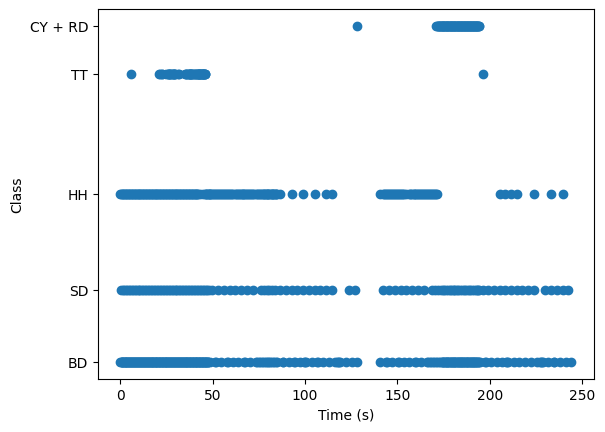

In [61]:

midi = all_scenes[310]['music_path'] + 'mixture.wav.mid'
transcription = pretty_midi.PrettyMIDI(midi)

plt.scatter([note.start for note in transcription.instruments[0].notes], [note.pitch for note in transcription.instruments[0].notes])
plt.yticks([35, 38, 42, 47, 49], ["BD", "SD", "HH", "TT", "CY + RD"])

plt.xlabel("Time (s)")
plt.ylabel("Class")
plt.show()

In [48]:
def turn_transcription_into_roll(transcription):
    # Determine your sampling frequency (frames per second)
    fs = 44100
    
    # Calculate the length of the piano roll. Find the maximum end time among all notes.
    max_end_time = max(note.end for note in transcription.instruments[0].notes)
    piano_roll_length = int(np.ceil(max_end_time * fs))
    
    # Initialize the piano roll array
    piano_roll = np.zeros((128, piano_roll_length))
    
    # Fill in the piano roll array
    for note in transcription.instruments[0].notes:
        # Convert start and end times to frame indices
        start_frame = int(np.floor(note.start * fs))
        end_frame = int(np.ceil(note.end * fs))
        
        # Set the corresponding frames to 1 (or note.velocity for a velocity-sensitive representation)
        piano_roll[note.pitch, start_frame:end_frame] = 1  # Or use note.velocity
        
    roll = np.vstack([piano_roll[34:36, :], piano_roll[37:39, :], piano_roll[41:43, :], piano_roll[46:48, :], piano_roll[48:50, :]])
    return roll

# Data Loaders

In [9]:
class AudioDataGenerator(Dataset):
    def __init__(self, data, sample_rate=HDEMUCS_HIGH_MUSDB.sample_rate, segment_length = 10):
        self.data = data
        self.sample_rate = sample_rate
        self.segment_length = sample_rate * segment_length

    def __len__(self):
        return len(self.data)
    
    def load_audio(self, path, start_point, filename):
        audio_tensors = []
        file = filename
        segment, _ = torchaudio.load(f"{path}/{file}", frame_offset=start_point, num_frames=self.segment_length)
        audio_tensors.append(segment)
        return torch.cat(audio_tensors, dim=0)


    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]

        # Load audio as a tensor
        audio_path = sample['music_path']

        start_point = sample['start_point']

        mixture_tensor = self.load_audio(audio_path, start_point,'mixture.wav')
        bass_tensor = self.load_audio(audio_path, start_point,'bass.wav')
        drum_tensor = self.load_audio(audio_path, start_point,'drums.wav')
        other_tensor = self.load_audio(audio_path, start_point,'other.wav')
        vocal_tensor = self.load_audio(audio_path, start_point,'vocals.wav')

        return mixture_tensor,  bass_tensor, drum_tensor, other_tensor, vocal_tensor

## Lightning Data Module

In [10]:
class AudioDataModule(pl.LightningDataModule):
    def __init__(self, data, batch_size=32, num_workers=0, persistent_workers=False, shuffle=False):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers=persistent_workers
        self.shuffle = shuffle

    def setup(self, stage=None):
        # Split your data here if necessary, e.g., into train, validation, test
        self.dataset = AudioDataGenerator(self.data)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle, num_workers = self.num_workers, persistent_workers=self.persistent_workers)

    # Implement val_dataloader() and test_dataloader() if you have validation and test data

## Lightning Callbacks

In [15]:
class SaveModelEveryNSteps(pl.Callback):
    def __init__(self, save_step_frequency=100,):
        self.save_step_frequency = save_step_frequency
        self.save_path = "D://Github//phd-musdb18-advanced//Data//models//WaveletNet//"
        os.makedirs(self.save_path , exist_ok=True)

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if (trainer.global_step + 1) % self.save_step_frequency == 0:
            checkpoint_path = os.path.join(self.save_path, f"step_{trainer.global_step + 1}.ckpt")
            trainer.save_checkpoint(checkpoint_path)

# Train Loop

In [16]:
model = TrainNetwork()

In [17]:
wandb_logger = WandbLogger(project='WaveletNet', log_model='all')

In [18]:
audio_data_module = AudioDataModule(all_scenes, batch_size=1, num_workers=0, persistent_workers=False)

In [19]:
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu", 
    devices=-1,
    logger=wandb_logger,
    callbacks=[SaveModelEveryNSteps()],
    # accumulate_grad_batches=2,
    gradient_clip_val=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, audio_data_module)

wandb: Currently logged in as: hephyrius. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | waveletnet | FNNModel  | 231 K 
1 | l1_loss    | L1Loss    | 0     
2 | sisnr_loss | SISDRLoss | 0     
-----------------------------------------
231 K     Trainable params
0         Non-trainable params
231 K     Total params
0.926     Total estimated model params size (MB)
C:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

torch.Size([1, 4, 2, 441000])
torch.Size([1, 4, 2, 441000])
torch.Size([1, 4, 2, 441000])
